In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

# 1 Analyse des données

In [2]:
Data = pd.read_csv('Airnbn.csv')
# Suppression des colonnes
to_deleted =['id','description', 'first_review', 'host_has_profile_pic', 'host_identity_verified', 
    'host_response_rate', 'host_since', 'last_review', 'latitude', 'longitude', 'name',
    'number_of_reviews', 'review_scores_rating', 'thumbnail_url', 'zipcode']
Data.drop(to_deleted, axis=1, inplace=True)
# Modification des log_price
Data['log_price']=Data['log_price'].apply(lambda x : math.exp(x))
Data.rename(columns={'log_price' : 'price'}, inplace=True)

In [3]:
# Suppression de données d'aménities vides
Data=Data[Data['amenities']!='{}']

In [4]:
# Suppression des doublons
print(f'nombre de doublons : {Data[Data.duplicated()].shape[0]}')
Data.drop_duplicates(inplace=True)

nombre de doublons : 249


In [5]:
# Conservation des locations comprises entre 20 et 1000 dollars
Data=Data[(Data['price']>20) & (Data['price']<1000)]
Data.shape

(72473, 14)

<Axes: xlabel='price', ylabel='Count'>

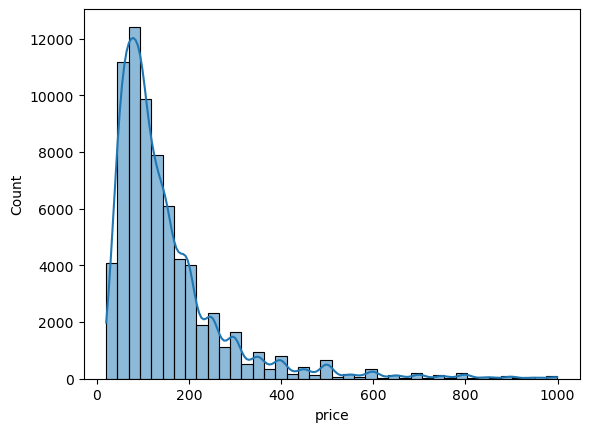

In [6]:
# Affichage de la répartion des prix
sns.histplot(Data, x='price',kde=True, bins=40)

<Axes: xlabel='price', ylabel='Count'>

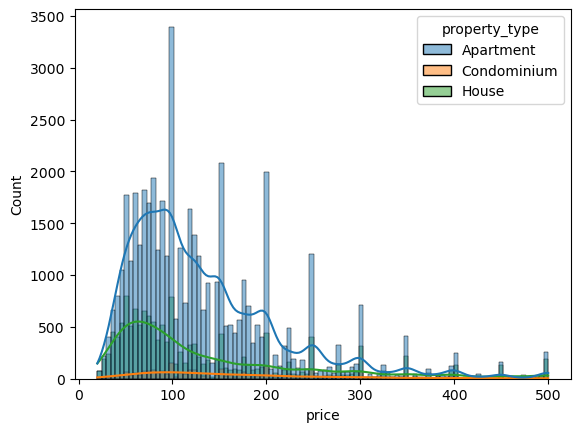

In [9]:
# Sélection des locations avec des prixx inférieurs à 500$
Data=Data[Data['price']<500]
# Selection des trois type de propriétés les plus importantes
property_type=Data['property_type'].value_counts()[:3]
Dt=Data[Data['property_type'].isin(property_type.index)]
sns.histplot(Dt, x='price',kde=True, hue='property_type',bins=100)
# Il semble que les locations des appartements semblent être plus élévés que les condominuim 

In [10]:
# Valeur moyenne des trois principales propriétés
Dt[['price','property_type']].groupby(by=['property_type']).mean()
# On constate que les prix moyens des condominium sont plus élevés que ce des appartement
# ce résultat semblent être en contradiction avec l'impression de l'affichage précédent
# La seule explication ne peut être due qu'au nombre plus important de prix élevés pour 
# les codominium que pour les appartements

,price
property_type,
Apartment,134.032870
Condominium,169.135396
House,138.810393


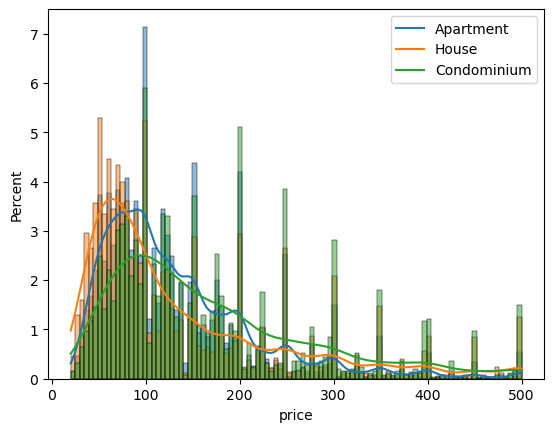

In [11]:
# Affichage de la répartition des prix par types de locations
legend=[]
for property in property_type.index:
    Dt_p=Dt[Dt['property_type']==property] ; legend.append(property)
    sns.histplot(Dt_p, x='price',kde=True, bins=100, stat='percent')
plt.legend(labels=legend)
# Ce mode d'affichage permet de mieux comprendre la moyenne des prix, on voit que le nombre
# de prix suppérieur à 200$ est plus important pour les codominium que pour les appartements 
# ce qui permet d'expliquer que le prix moyen des codominium soit plus important que celui des appartements

In [12]:
# La moyenne donne une information mais cela ne reste qu'une moyenne. La répartition autour de
# cette valeur est aussi une donnée à prendre en compte.

# 2  Traitement de instant_bookable

In [13]:
# Affichage du nombre de valeurs différentes dans les colonnes objets
columns_objets = Data.select_dtypes('object').columns
for col in columns_objets :
    print(f'{col :>20} : {len(Data[col].unique())}')

       property_type : 34
           room_type : 3
           amenities : 64853
            bed_type : 5
 cancellation_policy : 5
                city : 6
    instant_bookable : 2
       neighbourhood : 617


In [14]:
# Répartion du nombre de location de instant_bookable
Dt=pd.DataFrame(Data.groupby(['instant_bookable'])['price'].mean())
Dt['counts']=Data['instant_bookable'].value_counts()
Dt

,price,counts
instant_bookable,,
f,138.552106,52115
t,131.722840,18603


In [15]:
# Nombre de données manquantes
print(f'nombre de données manquantes : {Data.shape[0]-Dt["counts"].sum()}')

nombre de données manquantes : 0


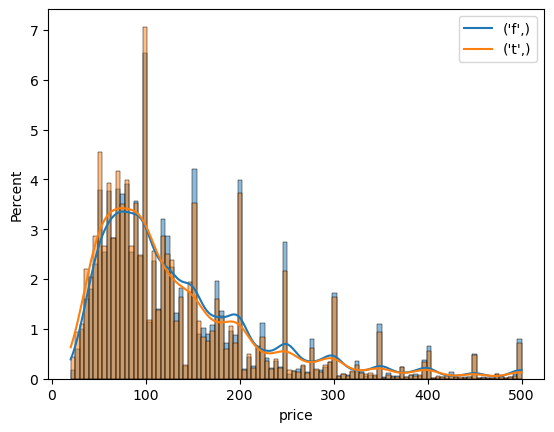

In [16]:
# Affichage des instant_bookable
DtGroup=Data.groupby(['instant_bookable'])
legend = []
for dt in DtGroup:
    sns.histplot(dt[1]['price'], kde=True, bins=100, stat='percent')
    legend.append(dt[0])
plt.legend(labels=legend)

In [17]:
# Les valeurs 'f' et 't' évoluent de manière similaire. Cette feature n'apporte aucune 
# information sur les prix des locations
Data.drop(['instant_bookable'], axis=1, inplace=True)

# 3 Traitement de room_type 

In [18]:
# Répartion du nombre de location de room_type
Dt=pd.DataFrame(Data.groupby(['room_type'])['price'].mean())
Dt['counts']=Data['room_type'].value_counts()
Dt
# Le prix moyens des appartements sont plus élevés que ceux des autres locations. 
# On peut avoir une hiarchisation et donc conserver une seule colonne.
# Mais uniquement se contenter de regarder la moyenne peut ne pas suffir.

,price,counts
room_type,,
Entire home/apt,181.250361,38772
Private room,84.211705,30004
Shared room,60.224511,1942


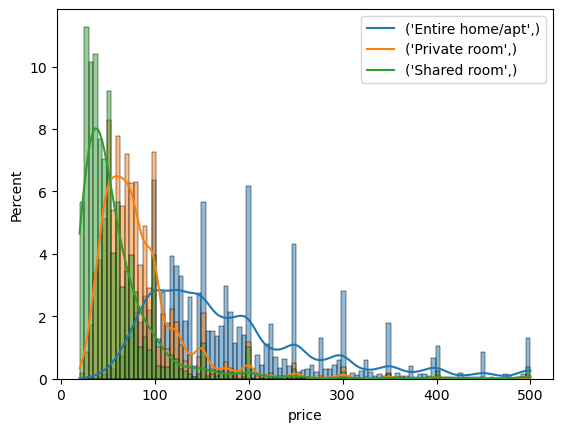

In [19]:
# Variation des prix en pourcentage
DtGroup=Data.groupby(['room_type'])
legend = []
for dt in DtGroup:
    sns.histplot(dt[1]['price'], kde=True, bins=100, stat='percent')
    legend.append(dt[0])
plt.legend(labels=legend)
# On constate bien qu'il y a une forte dichotomie entre les locations des 
# appartements celles de chambres individuelles et partagées.
# Une seule colonne peut suffire la numérotation doit conserver les ordres
# de grandeur. Une solution serait numéroter en conservant le poucentage

# 4 - Analyse des property_type 

In [20]:
# Affichage de nombre de chaque types de propriétés et des prix moyens
Data.groupby(['property_type'])['price'].aggregate(['count', 'mean']).sort_values(by='count')
# Au regard des résultats il est nécessaire soit de supprimer une partie 
# des types soit regrouper ceux qui se ressemblent.
# En particulier il y a des locations qui semble correspondre à des prestations
# de qualité (Timeshare) dans laquelle on pourrait regrouper les prestations équivalentes.

,count,mean
property_type,,
Casa particular,1,80.000000
Lighthouse,1,250.000000
Island,1,150.000000
Train,2,182.500000
Cave,2,136.000000
Tipi,3,232.333333
Earth House,3,141.666667
Chalet,5,138.000000
Treehouse,6,125.666667


In [21]:
# Regroupement des locations supérieures à 200$
Dt=Data.groupby(['property_type'])['price'].mean()>200
Timeshare=Dt[Dt==True].index
Data['property_type']=Data['property_type'].apply(lambda x : 'Timeshare' if x in Timeshare else x)
# Selection des types de propriétés à supprimer
Dt=Data['property_type'].value_counts()<=20
to_deleted=Dt[Dt==True].index
# Suppression des types de propriétés sélectionnés.
Data=Data[Data['property_type'].isin(to_deleted)==False]
Data.groupby(['property_type'])['price'].aggregate(['count', 'mean']).sort_values(by='count')

,count,mean
property_type,,
Hostel,44,77.227273
Boat,56,182.928571
Boutique hotel,64,159.515625
In-law,71,135.929577
Cabin,71,116.971831
Camper/RV,89,128.494382
Timeshare,91,243.615385
Guest suite,121,124.561983
Dorm,122,53.950820


# 5 - Analyse des bed_type 

In [22]:
# Affichage du nombre de lits et de la valeur moyenne de locations
Data.groupby(['bed_type'])['price'].aggregate(['count', 'mean']).sort_values(by='mean')

,count,mean
bed_type,,
Couch,251,82.446215
Airbed,451,85.370288
Futon,733,86.813097
Pull-out Sofa,579,100.594128
Real Bed,68632,138.136496


In [23]:
# Répartition des prix en fonctions des types propriétés et de lits
beds_mean=Data.groupby(['property_type', 'bed_type'],as_index=False)['price'].mean()
beds_mean.pivot(index='property_type', columns='bed_type', values='price')

bed_type,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
property_type,,,,,
Apartment,82.411079,78.730159,83.825000,98.951923,135.481323
Bed & Breakfast,55.000000,51.666667,80.857143,41.000000,114.263033
Boat,NaN,NaN,NaN,NaN,182.928571
Boutique hotel,NaN,NaN,NaN,NaN,159.515625
Bungalow,108.000000,99.000000,101.125000,91.250000,131.957020
Cabin,NaN,NaN,112.800000,80.000000,117.861538
Camper/RV,NaN,NaN,108.666667,62.000000,130.785714
Condominium,113.208333,92.538462,110.809524,112.291667,171.182385
Dorm,NaN,NaN,270.500000,NaN,50.341667


In [24]:
beds_count=Data.groupby(['property_type', 'bed_type'],as_index=False)['price'].count()
beds_count.pivot(index='property_type', columns='bed_type', values='price')

bed_type,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
property_type,,,,,
Apartment,343.0,189.0,480.0,416.0,46154.0
Bed & Breakfast,2.0,3.0,7.0,3.0,422.0
Boat,NaN,NaN,NaN,NaN,56.0
Boutique hotel,NaN,NaN,NaN,NaN,64.0
Bungalow,1.0,1.0,8.0,4.0,349.0
Cabin,NaN,NaN,5.0,1.0,65.0
Camper/RV,NaN,NaN,3.0,2.0,84.0
Condominium,24.0,13.0,21.0,24.0,2407.0
Dorm,NaN,NaN,2.0,NaN,120.0


In [26]:
# Les locations avec de vrais lits sont toujours bien plus chère.
# Les locations des couchages de types autre que les vrais lits sont très élevés.
Data[(Data['property_type']=='Other') & (Data['bed_type']=='Airbed')]
# On constate que le prix des Airbed est impacté par un sample qui pourrait être un outlier

,price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,neighbourhood,bedrooms,beds
35818,40.0,Other,Shared room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",4,1.0,Airbed,strict,True,LA,Del Rey,1.0,1.0
36530,40.0,Other,Private room,"{""Wireless Internet"",""Air conditioning"",""Wheel...",4,0.0,Airbed,flexible,False,LA,Cypress Park,1.0,1.0
60668,22.0,Other,Private room,"{Internet,""Air conditioning"",Kitchen,Breakfast...",1,0.5,Airbed,flexible,False,SF,Chinatown,1.0,1.0
62801,500.0,Other,Shared room,"{""Suitable for events"",Washer,Dryer,""Smoke det...",1,0.0,Airbed,strict,False,Boston,South End,1.0,1.0
72353,75.0,Other,Entire home/apt,"{""Wireless Internet"",""Free parking on premises...",1,1.0,Airbed,flexible,True,LA,NaN,0.0,1.0


# 6 Traitement de accommodates 

In [27]:
# Affichage des accommodements et de la valeur moyenne de locations
Data.groupby(['accommodates'])['price'].aggregate(['count', 'mean']).sort_values(by='mean')
# Les prix des locations sont clairement dépendant de cette feature

,count,mean
accommodates,,
1,9105,74.941021
2,31208,107.754134
3,7624,135.902545
4,11602,171.170057
5,3233,199.211259
6,4423,230.506670
7,825,246.539394
8,1415,267.479152
10,482,279.280083


In [28]:
# Affichage des prix moyens en fonction du nombre de salles de bains
Data.groupby(['bathrooms'])['price'].aggregate(['count','mean']).sort_values(by='mean')
# Le nombre de salles bains est étroitement lié au prix, exécpté lorque ce nombre est à 8

,count,mean
bathrooms,,
8.0,28,48.535714
6.5,2,49.000000
0.0,176,80.534091
0.5,198,85.712121
1.0,56737,123.634348
1.5,3635,140.928198
2.0,7219,200.766588
6.0,4,206.750000
2.5,1255,240.274900


In [29]:
# Toutes les locations sont soit des chambres partagées pour les moins ch§res
# soit des chambres privées pour celles un peu plus chère.
Data[Data['bathrooms']==8]
# Un encodage qui conserve le rapport entre le nombre de SDB et le prix moyen est plus cohérent

,price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,neighbourhood,bedrooms,beds
6076,30.0,House,Shared room,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,8.0,Real Bed,strict,True,NYC,Ridgewood,1.0,2.0
8140,27.0,Other,Shared room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,8.0,Real Bed,flexible,False,Chicago,Wrigleyville,1.0,4.0
8290,54.0,Dorm,Shared room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,8.0,Real Bed,flexible,True,DC,Adams Morgan,1.0,1.0
8384,54.0,Dorm,Shared room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,8.0,Real Bed,flexible,True,DC,Adams Morgan,1.0,1.0
11109,33.0,Dorm,Shared room,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1,8.0,Real Bed,flexible,False,LA,Mid-City,1.0,4.0
11140,54.0,Dorm,Shared room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,8.0,Real Bed,flexible,True,DC,Adams Morgan,1.0,1.0
11452,70.0,Hostel,Private room,"{TV,""Wireless Internet"",Heating,""Family/kid fr...",2,8.0,Real Bed,flexible,False,SF,Tenderloin,0.0,2.0
13253,100.0,Apartment,Private room,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,8.0,Real Bed,flexible,False,LA,Studio City,1.0,1.0
13370,35.0,Hostel,Shared room,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1,8.0,Real Bed,flexible,False,LA,Hollywood,1.0,1.0
14076,46.0,Dorm,Shared room,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",6,8.0,Real Bed,flexible,False,LA,Hollywood,1.0,6.0


# 7 - Numérisation des feature

In [30]:
# Estimation du nombre de valeurs manquantes par features
Data.isna().sum()

price                     0
property_type             0
room_type                 0
amenities                 0
accommodates              0
bathrooms               159
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
neighbourhood          6363
bedrooms                 87
beds                    102
dtype: int64

In [31]:
# Permet d'éviter les warning lors des mises à jour des features
pd.options.mode.copy_on_write = True

# On pourrait remplacer les valeurs manquantes dans les features bathrooms,
# bedrooms et beds par un 1. Si on choisi de supprimer ces valeurs
Data.dropna(how='any', axis=0, inplace=True)

In [32]:
# Sauvegarde des données originales
Data_originale = Data.copy()

In [33]:
# Représentation des types de chambre en fonction des prix moyens
PrixM=Data['price'].mean()
Dt=pd.DataFrame(Data.groupby(['room_type'])['price'].mean()/PrixM)
Data['room_type']=Data['room_type'].apply(lambda x : round(Dt.loc[x]['price'],3))

In [34]:
# Permet d'éviter les warning lors des mises à jour des features
pd.options.mode.copy_on_write = True
# Comme pour les types de location il serait convenable de numériser 
# les types de lits en fonction de leur importance
PrixM=Data['price'].mean()
Dt=pd.DataFrame(Data.groupby(['bed_type'])['price'].mean()/PrixM)
Data['bed_type']=Data['bed_type'].apply(lambda x : round(Dt.loc[x]['price'],3))

In [35]:
# Affichage des prix moyens en fonction de la variable cancelation
Data.groupby(['cancellation_policy'])['price'].aggregate(['count','mean']).sort_values(by='mean')

,count,mean
cancellation_policy,,
flexible,19075,124.183539
moderate,16844,130.413382
strict,27989,152.845368
super_strict_30,93,250.096774
super_strict_60,5,263.800000


In [36]:
# On peut regrouper les types d'annulation super_strict
super_strict = ['super_strict_30', 'super_strict_60']
Data['cancellation_policy']=Data['cancellation_policy'].apply(lambda x : 'super_strict' if x in super_strict else x)

In [37]:
# Modification des annulation en fonction de leur rapport
PrixM=Data['price'].mean()
Dt=pd.DataFrame(Data.groupby(['cancellation_policy'])['price'].mean()/PrixM)
Data['cancellation_policy']=Data['cancellation_policy'].apply(lambda x : round(Dt.loc[x]['price'],3))

In [38]:
# Modification des types de propriétés en fonction de leur rapport
PrixM=Data['price'].mean()
Dt=pd.DataFrame(Data.groupby(['property_type'])['price'].mean()/PrixM)
Data['property_type']=Data['property_type'].apply(lambda x : round(Dt.loc[x]['price'],3))

In [40]:
# Suppression des features objets
Objects=Data.select_dtypes('object').columns
Data.drop(Objects, axis=1, inplace=True)

In [41]:
# Afin d'avoir des données comparables nous allons normaliser les features 
# accommodate, bathrooms, bedrooms et beds
Means=Data['accommodates'].mean()
Data['accommodates']=Data['accommodates'].apply(lambda x : round(x/Means,3))
Means=Data['bathrooms'].mean()
Data['bathrooms']=Data['bathrooms'].apply(lambda x : round(x/Means,3))
Means=Data['bedrooms'].mean()
Data['bedrooms']=Data['bedrooms'].apply(lambda x : round(x/Means,3))
Means=Data['beds'].mean()
Data['beds']=Data['beds'].apply(lambda x : round(x/Means,3))

<Axes: >

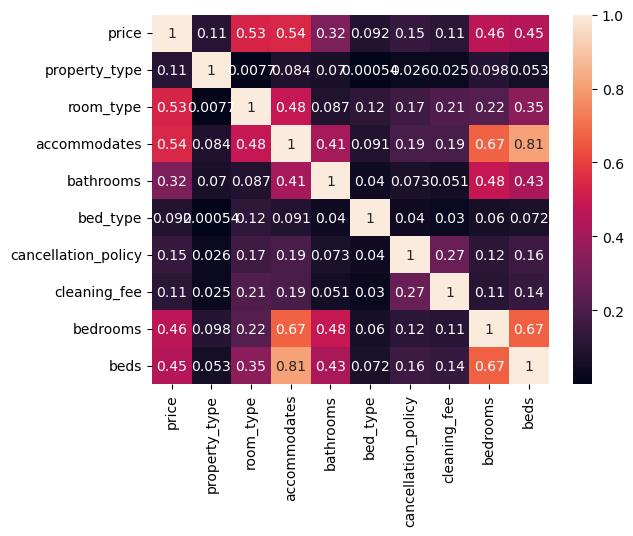

In [42]:
# Affichage des corrélations entre les features
sns.heatmap(Data.corr(), annot=True)

In [43]:
# Modèle d'isolatio Forest pour la recherche des outlier
from sklearn.ensemble import IsolationForest
model = IsolationForest(random_state=0, contamination=0.001)
model.fit(Data)
anomalies = np.where(model.predict(Data)==-1)

In [40]:
anomalies

(array([ 2292,  2761,  2852,  4147,  4639,  5113,  5173,  6278,  8912,
         9065, 10975, 11293, 11548, 12233, 13120, 16055, 16572, 16638,
        16746, 17001, 17299, 17996, 18686, 19852, 21247, 22162, 22703,
        23393, 25931, 26932, 27821, 28149, 28600, 33420, 33708, 33918,
        35515, 36959, 37641, 40446, 40936, 41985, 42685, 42932, 46440,
        46476, 48637, 49174, 50023, 52402, 52757, 53548, 54324, 55249,
        55784, 55818, 56636, 56927, 58336, 58719, 60061, 60193, 61654,
        62206, 63123]),)

In [41]:
# récupération des outliers
Outliers=Data_originale.iloc[anomalies]
Outliers

,price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,neighbourhood,bedrooms,beds
2643,499.0,Dorm,Shared room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1.0,Futon,flexible,False,LA,Sherman Oaks,1.0,1.0
3190,500.0,Condominium,Entire home/apt,"{TV,""Wireless Internet"",Kitchen,""Family/kid fr...",5,2.0,Real Bed,strict,False,SF,Western Addition/NOPA,4.0,5.0
3293,429.0,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10,3.5,Real Bed,flexible,False,NYC,Emerson Hill,4.0,4.0
4807,425.0,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",16,5.0,Real Bed,strict,False,LA,West Athens,7.0,15.0
5374,367.0,Condominium,Entire home/apt,"{Kitchen,""Free parking on premises"",""Indoor fi...",8,2.5,Real Bed,flexible,False,SF,Hayes Valley,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69458,480.0,Hostel,Private room,"{""Wireless Internet"",""Air conditioning"",Pool,K...",8,2.0,Real Bed,moderate,False,LA,Downtown,1.0,8.0
69612,459.0,House,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",16,4.0,Real Bed,flexible,True,NYC,Flushing,8.0,12.0
71315,400.0,Condominium,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",16,3.0,Real Bed,strict,True,Chicago,Garfield Park,5.0,9.0
71977,500.0,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10,4.0,Real Bed,flexible,False,DC,16th Street Heights,4.0,6.0


<Axes: xlabel='price', ylabel='Count'>

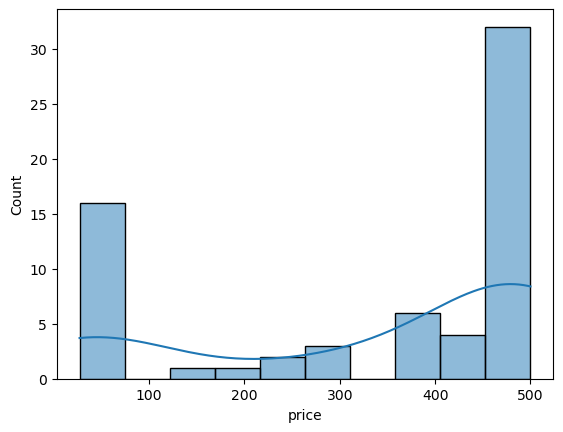

In [43]:
pd.options.mode.copy_on_write = False
sns.histplot(Outliers['price'], kde=True, bins=10)

<Axes: xlabel='accommodates', ylabel='Count'>

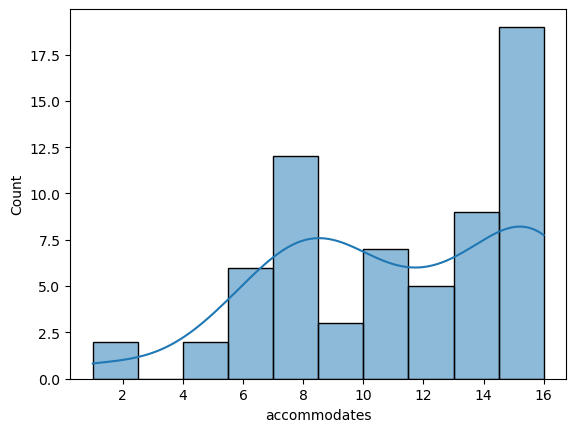

In [47]:
sns.histplot(Outliers['accommodates'], kde=True, bins=10)

<Axes: xlabel='bathrooms', ylabel='Count'>

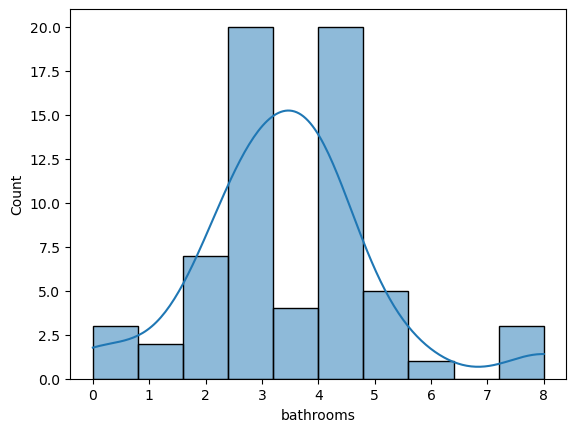

In [49]:
sns.histplot(Outliers['bathrooms'], kde=True, bins=10)

<Axes: xlabel='bedrooms', ylabel='Count'>

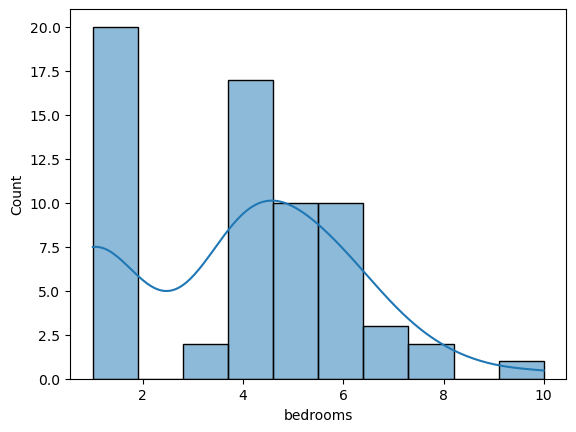

In [50]:
sns.histplot(Outliers['bedrooms'], kde=True, bins=10)